<a href="https://colab.research.google.com/github/paoandreachv/Practica/blob/Iceland/Islandia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PyGMTSAR Time series: Reykjavik, Iceland

Breve introducción


# Instalación de Google Colab

Instalaremos PyGMTSAR y los binarios requeridos de GMTSAR para que este software funcione (incluyendo SNAPHU, el cual es una herramienta complementaria usada específicamente para desenvolver fases interferométricas en imágenes de radar).


In [1]:
# Importaremos las librerías necesarias y se verifica si el código se está
# ejecutando en Google Colab.

import platform, sys, os

if 'google.colab' in sys.modules:
# Instalación de la librería PyGMTSAR
  !{sys.executable} -m pip install -q pygmtsar
  # Instalación de dependencias binarias
  import importlib.resources as resources
  with resources.as_file(resources.files('pygmtsar.data') / 'google_colab.sh') as google_colab_script_filename:
      !sh {google_colab_script_filename}
  # Vamos a permitir la visualización interactiva de datos
  from google.colab import output
  output.enable_custom_widget_manager()
  # Se inicializa un espacio de memoria (buffer) que simula una pantalla, permitiendo realizar operaciones gráficas 3D
  import xvfbwrapper
  display = xvfbwrapper.Xvfb(width=800, height=600)
  display.start()

# Configuramos la variable de entorno PATH para que incluya la ruta de instalación de GMTSAR
PATH = os.environ['PATH']
if PATH.find('GMTSAR') == -1:
    PATH = os.environ['PATH'] + ':/usr/local/GMTSAR/bin/'
    %env PATH {PATH}

# Se imprime la versión de PyGMTSAR que se ha instalado.
from pygmtsar import __version__
__version__


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 103.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.1 MB/s eta 0:00:00
W: Skipping acquire of configured file 'main/source/Sourc

'2024.8.30.post5'

# Cargar y configurar módulos de Python

In [2]:
# Se utiliza para trabajar con datos multidimensionales, como los datos de SAR.
import xarray as xr

# Permite trabajar con matrices y operaciones numéricas.
import numpy as np

# Se utiliza para manipular y analizar datos tabulares.
import pandas as pd

# Se utiliza para trabajar datos geoespaciales.
import geopandas as gpd

# Se usa comúnmente para almacenar y transferir datos.
import json

# Dask es ideal para trabajos que no caben en la memoria de un solo equipo.
from dask.distributed import Client

# Procesa grandes conjuntos de datos
import dask

Esta parte del código se encarga de importar y configurar las librerías necesarias para la visualización de los datos. Se divide en dos partes importantes:

- Módulos de gráficos


In [3]:
# define Pandas display settings/configura las opciones de visualización de Pandas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

In [4]:
# Módulos de gráficos

# Importa la librería de PyVista (pv), que se usa para la
# visualización 3D interactiva.
import pyvista as pv

# Configura el tema de PyVista a "document", que generalmente
# usa un fondo blanco para las gráficas.
pv.set_plot_theme("document")

# Importa la librería Panel, que se usa para crear paneles interactivos
# y visualizaciones web.
import panel

# Habilita la comunicación entre Panel y los widgets de Jupyter.
panel.extension(comms='ipywidgets')

# Habilita el soporte para visualizaciones VTK (Visualization Toolkit)
# en Panel, lo que permite integrar PyVista.
panel.extension('vtk')

# Importa contextmanager para manejar el contexto de la configuración de Matplotlib
from contextlib import contextmanager

# Importa la librería Matplotlib (plt), que se usa para crear gráficos estáticos.

import matplotlib.pyplot as plt

## Se define una función mpl_setting y configura los parámetros de Matplotlib


# Con esto se define el administrador de contexto, el cual controla lo que ocurre
# antes y después de ejecutar un bloque de código.
@contextmanager

# La función mpl_settings es un administrador de contexto, es decir, es una funcionalidad
# que permite ejecutar un bloque de código dentro de un entorno controlado. Este entorno
# generalmente asegura que se realicen ciertas acciones antes y después de ejecutar ese bloque
# de código, como configurar algo temporalmente y luego restaurarlo al finalizar. Lo que
# generará este administrador de contexto es que permitirá cambiar temporalmente la configuración
# de Matplotlib y luego restaurarla a su estado original.

def mpl_settings(settings):
    original_settings = {k: plt.rcParams[k] for k in settings}
    plt.rcParams.update(settings)
    yield
    plt.rcParams.update(original_settings)

plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
%matplotlib inline

In [5]:
# Configura las opciones de visualización de Pandas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

In [6]:
# Se importan varias clases y funciones de la librería PyGMTSAR, que se usa para el
# procesamiento de datos de interferomoetría de radar de apertura sintética (InSAR).

from pygmtsar import S1, Stack, tqdm_dask, ASF, Tiles

## Escenas SLC de Sentinel-1 y parámetros de procesamiento


### Descending Orbit Configuration

In [72]:
# El subswath se utiliza exclusivamente cuando se necesitan descargar partes
# específicas de una escena, pero no es necesario cuando se descargan datos
# completos de una ráfaga. En cambio, la órbita sirve para establecer los nombres
# de los directorios donde se guardan los datos procesados.

ORBIT    = 'D'
SUBSWATH = 12
REFERENCE = '2024-11-06'

In [73]:
BURSTS = """
S1_032601_IW1_20241212T185929_VV_5016-BURST
S1_032600_IW2_20241212T185927_VV_5016-BURST
S1_032600_IW1_20241212T185926_VV_5016-BURST
S1_032599_IW2_20241212T185924_VV_5016-BURST
S1_032599_IW1_20241212T185923_VV_708B-BURST
S1_032598_IW2_20241212T185921_VV_708B-BURST
S1_032601_IW1_20241118T185930_VV_2338-BURST
S1_032600_IW2_20241118T185929_VV_2338-BURST
S1_032600_IW1_20241118T185928_VV_2338-BURST
S1_032599_IW2_20241118T185926_VV_2338-BURST
S1_032599_IW1_20241118T185925_VV_76C3-BURST
S1_032598_IW2_20241118T185923_VV_76C3-BURST
S1_032601_IW1_20241106T185931_VV_A266-BURST
S1_032600_IW2_20241106T185929_VV_A266-BURST
S1_032600_IW1_20241106T185928_VV_A266-BURST
S1_032599_IW2_20241106T185926_VV_A266-BURST
S1_032599_IW1_20241106T185925_VV_65EA-BURST
S1_032598_IW2_20241106T185923_VV_65EA-BURST
S1_032601_IW1_20241025T185931_VV_9FCC-BURST
S1_032600_IW2_20241025T185929_VV_9FCC-BURST
S1_032600_IW1_20241025T185928_VV_9FCC-BURST
S1_032599_IW2_20241025T185926_VV_9FCC-BURST
S1_032599_IW1_20241025T185925_VV_F0F8-BURST
S1_032598_IW2_20241025T185923_VV_F0F8-BURST
S1_032601_IW1_20241013T185931_VV_E4A9-BURST
S1_032600_IW2_20241013T185929_VV_E4A9-BURST
S1_032600_IW1_20241013T185928_VV_E4A9-BURST
S1_032599_IW2_20241013T185926_VV_E4A9-BURST
S1_032599_IW1_20241013T185926_VV_03AB-BURST
S1_032598_IW2_20241013T185924_VV_03AB-BURST
S1_032601_IW1_20241001T185931_VV_68D0-BURST
S1_032600_IW2_20241001T185929_VV_68D0-BURST
S1_032600_IW1_20241001T185928_VV_68D0-BURST
S1_032599_IW2_20241001T185926_VV_68D0-BURST
S1_032599_IW1_20241001T185925_VV_3948-BURST
S1_032598_IW2_20241001T185923_VV_3948-BURST
S1_032601_IW1_20240919T185931_VV_9058-BURST
S1_032600_IW2_20240919T185929_VV_9058-BURST
S1_032600_IW1_20240919T185928_VV_9058-BURST
S1_032599_IW2_20240919T185926_VV_9058-BURST
S1_032599_IW1_20240919T185925_VV_2438-BURST
S1_032598_IW2_20240919T185923_VV_2438-BURST
S1_032601_IW1_20240907T185930_VV_0A43-BURST
S1_032600_IW2_20240907T185928_VV_0A43-BURST
S1_032600_IW1_20240907T185927_VV_0A43-BURST
S1_032599_IW2_20240907T185926_VV_0A43-BURST
S1_032599_IW1_20240907T185925_VV_279A-BURST
S1_032598_IW2_20240907T185923_VV_279A-BURST
S1_032601_IW1_20240826T185930_VV_4B95-BURST
S1_032600_IW2_20240826T185928_VV_4B95-BURST
S1_032600_IW1_20240826T185927_VV_4B95-BURST
S1_032599_IW2_20240826T185925_VV_4B95-BURST
S1_032599_IW1_20240826T185924_VV_DEAF-BURST
S1_032598_IW2_20240826T185923_VV_DEAF-BURST
S1_032601_IW1_20240814T185929_VV_CF04-BURST
S1_032600_IW2_20240814T185928_VV_CF04-BURST
S1_032600_IW1_20240814T185927_VV_CF04-BURST
S1_032599_IW2_20240814T185925_VV_CF04-BURST
S1_032599_IW1_20240814T185924_VV_46C5-BURST
S1_032598_IW2_20240814T185922_VV_46C5-BURST
S1_032601_IW1_20240802T185930_VV_0008-BURST
S1_032600_IW2_20240802T185928_VV_0008-BURST
S1_032600_IW1_20240802T185927_VV_0008-BURST
S1_032599_IW2_20240802T185925_VV_0008-BURST
S1_032599_IW1_20240802T185924_VV_9A0C-BURST
S1_032598_IW2_20240802T185922_VV_9A0C-BURST
S1_032601_IW1_20240721T185930_VV_3420-BURST
S1_032600_IW2_20240721T185928_VV_3420-BURST
S1_032600_IW1_20240721T185927_VV_3420-BURST
S1_032599_IW2_20240721T185925_VV_3420-BURST
S1_032599_IW1_20240721T185924_VV_E3CB-BURST
S1_032598_IW2_20240721T185922_VV_E3CB-BURST
S1_032601_IW1_20240709T185930_VV_0D9B-BURST
S1_032600_IW2_20240709T185928_VV_0D9B-BURST
S1_032600_IW1_20240709T185927_VV_0D9B-BURST
S1_032599_IW2_20240709T185926_VV_0D9B-BURST
S1_032599_IW1_20240709T185925_VV_4331-BURST
S1_032598_IW2_20240709T185923_VV_4331-BURST
S1_032601_IW1_20240615T185931_VV_34C1-BURST
S1_032600_IW2_20240615T185929_VV_34C1-BURST
S1_032600_IW1_20240615T185929_VV_34C1-BURST
S1_032599_IW2_20240615T185927_VV_34C1-BURST
S1_032599_IW1_20240615T185926_VV_C7FF-BURST
S1_032598_IW2_20240615T185924_VV_C7FF-BURST
S1_032601_IW1_20240603T185932_VV_2053-BURST
S1_032600_IW2_20240603T185930_VV_2053-BURST
S1_032600_IW1_20240603T185929_VV_2053-BURST
S1_032599_IW2_20240603T185927_VV_2053-BURST
S1_032599_IW1_20240603T185926_VV_530D-BURST
S1_032598_IW2_20240603T185924_VV_530D-BURST
S1_032601_IW1_20240522T185932_VV_503B-BURST
S1_032600_IW2_20240522T185930_VV_503B-BURST
S1_032600_IW1_20240522T185929_VV_503B-BURST
S1_032599_IW2_20240522T185927_VV_503B-BURST
S1_032599_IW1_20240522T185926_VV_2E58-BURST
S1_032598_IW2_20240522T185924_VV_2E58-BURST
S1_032601_IW1_20240510T185932_VV_DA22-BURST
S1_032600_IW2_20240510T185931_VV_DA22-BURST
S1_032600_IW1_20240510T185930_VV_DA22-BURST
S1_032599_IW2_20240510T185928_VV_DA22-BURST
S1_032599_IW1_20240510T185927_VV_6807-BURST
S1_032598_IW2_20240510T185925_VV_6807-BURST
S1_032601_IW1_20240428T185932_VV_F923-BURST
S1_032600_IW2_20240428T185930_VV_F923-BURST
S1_032600_IW1_20240428T185929_VV_F923-BURST
S1_032599_IW2_20240428T185928_VV_F923-BURST
S1_032599_IW1_20240428T185927_VV_FA18-BURST
S1_032598_IW2_20240428T185925_VV_FA18-BURST
S1_032601_IW1_20240416T185932_VV_1170-BURST
S1_032600_IW2_20240416T185930_VV_1170-BURST
S1_032600_IW1_20240416T185929_VV_1170-BURST
S1_032599_IW2_20240416T185927_VV_1170-BURST
S1_032599_IW1_20240416T185926_VV_546F-BURST
S1_032598_IW2_20240416T185924_VV_546F-BURST
S1_032601_IW1_20240404T185932_VV_5561-BURST
S1_032600_IW2_20240404T185930_VV_5561-BURST
S1_032600_IW1_20240404T185929_VV_5561-BURST
S1_032599_IW2_20240404T185927_VV_5561-BURST
S1_032599_IW1_20240404T185926_VV_3D92-BURST
S1_032598_IW2_20240404T185924_VV_3D92-BURST
S1_032601_IW1_20240323T185931_VV_934B-BURST
S1_032600_IW2_20240323T185929_VV_934B-BURST
S1_032600_IW1_20240323T185928_VV_934B-BURST
S1_032599_IW2_20240323T185926_VV_934B-BURST
S1_032599_IW1_20240323T185926_VV_D9D1-BURST
S1_032598_IW2_20240323T185924_VV_D9D1-BURST
S1_032601_IW1_20240311T185931_VV_3CAD-BURST
S1_032600_IW2_20240311T185929_VV_3CAD-BURST
S1_032600_IW1_20240311T185928_VV_3CAD-BURST
S1_032599_IW2_20240311T185926_VV_3CAD-BURST
S1_032599_IW1_20240311T185925_VV_4CF6-BURST
S1_032598_IW2_20240311T185923_VV_4CF6-BURST
S1_032601_IW1_20240228T185931_VV_8FFC-BURST
S1_032600_IW2_20240228T185929_VV_8FFC-BURST
S1_032600_IW1_20240228T185928_VV_8FFC-BURST
S1_032599_IW2_20240228T185926_VV_8FFC-BURST
S1_032599_IW1_20240228T185925_VV_B240-BURST
S1_032598_IW2_20240228T185923_VV_B240-BURST
S1_032601_IW1_20240216T185931_VV_0C81-BURST
S1_032600_IW2_20240216T185929_VV_0C81-BURST
S1_032600_IW1_20240216T185928_VV_0C81-BURST
S1_032599_IW2_20240216T185926_VV_0C81-BURST
S1_032599_IW1_20240216T185925_VV_3C9E-BURST
S1_032598_IW2_20240216T185923_VV_3C9E-BURST
S1_032601_IW1_20240204T185931_VV_B00B-BURST
S1_032600_IW2_20240204T185929_VV_B00B-BURST
S1_032600_IW1_20240204T185928_VV_B00B-BURST
S1_032599_IW2_20240204T185926_VV_B00B-BURST
S1_032599_IW1_20240204T185925_VV_21A9-BURST
S1_032598_IW2_20240204T185924_VV_21A9-BURST
S1_032601_IW1_20240123T185931_VV_870A-BURST
S1_032600_IW2_20240123T185929_VV_870A-BURST
S1_032600_IW1_20240123T185928_VV_870A-BURST
S1_032599_IW2_20240123T185927_VV_870A-BURST
S1_032599_IW1_20240123T185926_VV_B037-BURST
S1_032598_IW2_20240123T185924_VV_B037-BURST
S1_032601_IW1_20240111T185932_VV_C0CA-BURST
S1_032600_IW2_20240111T185930_VV_C0CA-BURST
S1_032600_IW1_20240111T185929_VV_C0CA-BURST
S1_032599_IW2_20240111T185927_VV_C0CA-BURST
S1_032599_IW1_20240111T185926_VV_67C4-BURST
S1_032598_IW2_20240111T185924_VV_67C4-BURST
S1_032601_IW1_20231230T185932_VV_7023-BURST
S1_032600_IW2_20231230T185931_VV_7023-BURST
S1_032600_IW1_20231230T185930_VV_7023-BURST
S1_032599_IW2_20231230T185928_VV_7023-BURST
S1_032599_IW1_20231230T185927_VV_D949-BURST
S1_032598_IW2_20231230T185925_VV_D949-BURST
S1_032601_IW1_20231218T185933_VV_F053-BURST
S1_032600_IW2_20231218T185931_VV_F053-BURST
S1_032600_IW1_20231218T185930_VV_F053-BURST
S1_032599_IW2_20231218T185928_VV_F053-BURST
S1_032599_IW1_20231218T185927_VV_24D8-BURST
S1_032598_IW2_20231218T185926_VV_24D8-BURST
S1_032601_IW1_20231206T185934_VV_78A8-BURST
S1_032600_IW2_20231206T185932_VV_78A8-BURST
S1_032600_IW1_20231206T185931_VV_78A8-BURST
S1_032599_IW2_20231206T185929_VV_78A8-BURST
S1_032599_IW1_20231206T185928_VV_9694-BURST
S1_032598_IW2_20231206T185926_VV_9694-BURST
S1_032601_IW1_20231124T185934_VV_0934-BURST
S1_032600_IW2_20231124T185932_VV_0934-BURST
S1_032600_IW1_20231124T185931_VV_0934-BURST
S1_032599_IW2_20231124T185929_VV_0934-BURST
S1_032599_IW1_20231124T185928_VV_16B9-BURST
S1_032598_IW2_20231124T185926_VV_16B9-BURST
S1_032601_IW1_20231112T185935_VV_6A84-BURST
S1_032600_IW2_20231112T185933_VV_6A84-BURST
S1_032600_IW1_20231112T185932_VV_6A84-BURST
S1_032599_IW2_20231112T185930_VV_6A84-BURST
S1_032599_IW1_20231112T185929_VV_43BA-BURST
S1_032598_IW2_20231112T185927_VV_43BA-BURST
S1_032601_IW1_20231031T185935_VV_C8B1-BURST
S1_032600_IW2_20231031T185933_VV_C8B1-BURST
S1_032600_IW1_20231031T185932_VV_C8B1-BURST
S1_032599_IW2_20231031T185930_VV_C8B1-BURST
S1_032599_IW1_20231031T185929_VV_F427-BURST
S1_032598_IW2_20231031T185927_VV_F427-BURST
S1_032601_IW1_20231019T185935_VV_60F5-BURST
S1_032600_IW2_20231019T185933_VV_60F5-BURST
S1_032600_IW1_20231019T185932_VV_60F5-BURST
S1_032599_IW2_20231019T185930_VV_60F5-BURST
S1_032599_IW1_20231019T185930_VV_83C1-BURST
S1_032598_IW2_20231019T185928_VV_83C1-BURST
S1_032601_IW1_20231007T185935_VV_CCCE-BURST
S1_032600_IW2_20231007T185933_VV_CCCE-BURST
S1_032600_IW1_20231007T185932_VV_CCCE-BURST
S1_032599_IW2_20231007T185930_VV_CCCE-BURST
S1_032599_IW1_20231007T185929_VV_19F5-BURST
S1_032598_IW2_20231007T185928_VV_19F5-BURST
S1_032601_IW1_20230925T185935_VV_384D-BURST
S1_032600_IW2_20230925T185933_VV_384D-BURST
S1_032600_IW1_20230925T185932_VV_384D-BURST
S1_032599_IW2_20230925T185930_VV_384D-BURST
S1_032599_IW1_20230925T185929_VV_B6CD-BURST
S1_032598_IW2_20230925T185928_VV_B6CD-BURST
S1_032601_IW1_20230913T185934_VV_3F63-BURST
S1_032600_IW2_20230913T185933_VV_3F63-BURST
S1_032600_IW1_20230913T185932_VV_3F63-BURST
S1_032599_IW2_20230913T185930_VV_3F63-BURST
S1_032599_IW1_20230913T185929_VV_DCD6-BURST
S1_032598_IW2_20230913T185927_VV_DCD6-BURST
S1_032601_IW1_20230901T185934_VV_601C-BURST
S1_032600_IW2_20230901T185932_VV_601C-BURST
S1_032600_IW1_20230901T185931_VV_601C-BURST
S1_032599_IW2_20230901T185930_VV_601C-BURST
S1_032599_IW1_20230901T185929_VV_2CAE-BURST
S1_032598_IW2_20230901T185927_VV_2CAE-BURST
"""

BURSTS = list(filter(None, BURSTS.split('\n')))

print(f'Bursts defined: {len(BURSTS)}')

Bursts defined: 228


In [74]:
WORKDIR = 'raw_reykjavik_iceland'  if ORBIT == 'D' else 'raw_reykjavik_iceland'
DATADIR = 'data_reykjavik_iceland' if ORBIT == 'D' else 'data_reykjavik_iceland'

In [75]:
# define DEM and landmask filenames inside data directory
DEM = f'{DATADIR}/dem.nc'

In [76]:
geojson = '''
{
  "type": "Feature",
  "properties": {},
  "geometry": {
    "type": "Polygon",
    "coordinates": [
      [
        [-23.03, 63.77],
        [-22.95, 64.21],
        [-21.25, 64.14],
        [-21.35, 63.70]
      ]
    ]
  }
}
'''
AOI = gpd.GeoDataFrame.from_features([json.loads(geojson)])
AOI

,geometry
0,"POLYGON ((-23.03 63.77, -22.95 64.21, -21.25 64.14, -21.35 63.7, -23.03 63.77))"


In [77]:
BUFFER = 0.025

# Si la geometría definida es demasiado pequeña para que el procesamiento funcione
# correctamente se amplía la geometría para que cumpla con los requisitos mínimos del proceso.

AOI['geometry'] = AOI.buffer(BUFFER)

In [78]:
# Punto donde emerge el magma

geojson = '''
{
  "type": "Feature",
  "geometry": {
    "type": "Point",
    "coordinates": [-22.38, 63.88]
  },
  "properties": {}
}
'''
POI = gpd.GeoDataFrame.from_features([json.loads(geojson)])
POI

,geometry
0,POINT (-22.38 63.88)


In [79]:
# Punto de referencia
geojson = '''
{
  "type": "Feature",
  "geometry": {
    "type": "Point",
    "coordinates": [-22.51, 63.97]
  },
  "properties": {}
}
'''
POI0 = gpd.GeoDataFrame.from_features([json.loads(geojson)])
POI0

,geometry
0,POINT (-22.51 63.97)


## Download and Unpack Datasets

## Enter Your ASF User and Password

**Esta sección se encarga de obtener las imágenes Sentinel-1 necesarias para el análisis InSAR**

If the data directory is empty or doesn't exist, you'll need to download Sentinel-1 scenes from the Alaska Satellite Facility (ASF) datastore. Use your Earthdata Login credentials. If you don't have an Earthdata Login, you can create one at https://urs.earthdata.nasa.gov//users/new

You can also use pre-existing SLC scenes stored on your Google Drive, or you can copy them using a direct public link from iCloud Drive.

The credentials below are available at the time the notebook is validated.

In [80]:
# Set these variables to None and you will be prompted to enter your username and password below.
#Son variables para guardar mis credenciales
asf_username = 'GoogleColab2023' # paao.ndra_2024
asf_password = 'GoogleColab_2023' # "arroba"Paola685067512

In [81]:
# Acá se crea un objeto ASF para interactuar con el repositorio ASF usando mis credenciales
asf = ASF(asf_username, asf_password)

# Descarga las escenas definidas en la lista SCENES al directorio DATADIR, solo las que
# coinciden con el sub-swath especificado en SUBSWATH.
print(asf.download(DATADIR, BURSTS))

ASF Downloading Bursts Catalog:   0%|          | 0/1 [00:00<?, ?it/s]

ASF Downloading Sentinel-1 Bursts:   0%|          | 0/228 [00:00<?, ?it/s]

                                  burst_or_scene
0    S1_032601_IW1_20241212T185929_VV_5016-BURST
1    S1_032600_IW2_20241212T185927_VV_5016-BURST
2    S1_032600_IW1_20241212T185926_VV_5016-BURST
3    S1_032599_IW2_20241212T185924_VV_5016-BURST
4    S1_032599_IW1_20241212T185923_VV_708B-BURST
5    S1_032598_IW2_20241212T185921_VV_708B-BURST
6    S1_032601_IW1_20241118T185930_VV_2338-BURST
7    S1_032600_IW2_20241118T185929_VV_2338-BURST
8    S1_032600_IW1_20241118T185928_VV_2338-BURST
9    S1_032599_IW2_20241118T185926_VV_2338-BURST
10   S1_032599_IW1_20241118T185925_VV_76C3-BURST
11   S1_032598_IW2_20241118T185923_VV_76C3-BURST
12   S1_032601_IW1_20241106T185931_VV_A266-BURST
13   S1_032600_IW2_20241106T185929_VV_A266-BURST
14   S1_032600_IW1_20241106T185928_VV_A266-BURST
15   S1_032599_IW2_20241106T185926_VV_A266-BURST
16   S1_032599_IW1_20241106T185925_VV_65EA-BURST
17   S1_032598_IW2_20241106T185923_VV_65EA-BURST
18   S1_032601_IW1_20241025T185931_VV_9FCC-BURST
19   S1_032600_IW2_2

In [82]:
# Este código tiene la función de buscar y descargar las órbitas de los satélites que
# faltan para procesar las escenas Sentinel-1 que ya se han descargado.
S1.download_orbits(DATADIR, S1.scan_slc(DATADIR))

NOTE: Found multiple scenes for a single day, use function Stack.reframe() to stitch the scenes


NOTE: Target file exists, return it. Use "skip_exist=False" or omit the filename to allow new downloading.


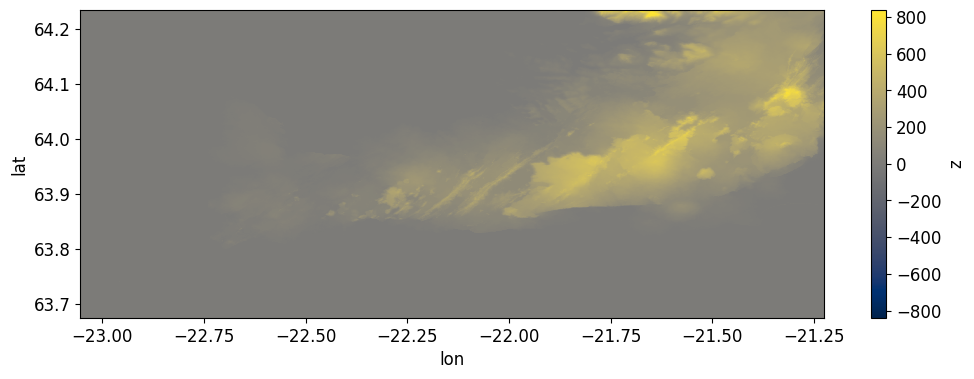

In [83]:
# Este código se encarga de descargar un DEM de Copernicus y mostrarlo como una imagen
Tiles().download_dem(AOI, filename=DEM).plot.imshow(cmap='cividis')

## Run Local Dask Cluster

Launch Dask cluster for local and distributed multicore computing. That's possible to process terabyte scale Sentinel-1 SLC datasets on Apple Air 16 GB RAM.

In [84]:
# simple Dask initialization
if 'client' in globals():
    client.close()
client = Client()
client

INFO:distributed.scheduler:Remove client Client-ba9da794-d384-11ef-8667-0242ac1c0002
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:44760; closing.
INFO:distributed.scheduler:Remove client Client-ba9da794-d384-11ef-8667-0242ac1c0002
INFO:distributed.scheduler:Close client connection: Client-ba9da794-d384-11ef-8667-0242ac1c0002
INFO:distributed.scheduler:Retire worker addresses (0, 1)
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:44633'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:34689'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:35846; closing.
INFO:distributed.scheduler:Remove worker <WorkerState 'tcp://127.0.0.1:41313', name: 0, status: closing, memory: 0, processing: 0> (stimulus_id='handle-worker-cleanup-1736975327.232732')
INFO:di

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 12.67 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42043,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 12.67 GiB
Comm: tcp://127.0.0.1:40731,Total threads: 1
Dashboard: http://127.0.0.1:45179/status,Memory: 6.34 GiB
Nanny: tcp://127.0.0.1:44111,


# ¿Por qué se utiliza Dask?

Dask es una librería de Python para computación paralela y distribuida. Permite procesar grandes conjuntos de datos que no caben en la memora RAM de una sola máquina. En este caso, se utiliza Dask para acelerar el procesamiento InSAR, ya que las imágenes Sentinel-1 pueden ser bastante grandes.

### Select Original Scenes and Download DEM and Orbits Later

Use filters to find required subswath, polarization and orbit in original scenes. SAFE directories in the data directory.

# ¿Qué es SBAS?

SBAS significa "Small Baseline Subset" (Conjunto de Líneas Base Pequeñas). Es una técnica usada en InSAR (Interferometría de Radar de Apertura Sintética) que toma varias imágenes de radar (SAR) de un mismo lugar tomadas en diferentes momentos. Luego, selecciona imágenes que estén cerca en tiempo y que tengan pequeñas diferencias de posición entre las órbitas del satélite, para así, combinar estas imágenes para detectar y medir cambios en la superficie del terreno (como deformaciones, subsidencia o movimientos).

El objetivo de SBAS es generar mapas detallados y precisos de cómo se deforma el terreno con el tiempo.

In [85]:
#Se buscan las scenas Sentinel-1 (SLC) dentro del directorio de datos (DATADIR) que
#coincidan con el sub-swath y la polarización espeificada. Esto se guarda en la variable scenes.
scenes = S1.scan_slc(DATADIR, subswath=SUBSWATH)

NOTE: Found multiple scenes for a single day, use function Stack.reframe() to stitch the scenes


In [86]:
sbas = Stack(WORKDIR, drop_if_exists=True).set_scenes(scenes).set_reference(REFERENCE)
sbas.to_dataframe()

NOTE: auto set reference scene 2023-09-01. You can change it like Stack.set_reference("2022-01-20")


,datetime,orbit,mission,polarization,subswath,datapath,metapath,noisepath,calibpath,orbitpath,geometry
date,,,,,,,,,,,
2023-09-01,2023-09-01 18:59:29,A,S1A,VV,1,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230901T185929_20230901T185932_050138_0608BD_2CAE.SAFE/...,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230901T185929_20230901T185932_050138_0608BD_2CAE.SAFE/...,None,None,data_reykjavik_iceland/S1A_OPER_AUX_POEORB_OPOD_20230921T080711_V20230831T225942_20230902T005942...,"MULTIPOLYGON (((-23.62431 63.61711, -23.53009 63.62714, -23.43673 63.637, -23.3442 63.64672, -23..."
2023-09-01,2023-09-01 18:59:31,A,S1A,VV,1,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230901T185931_20230901T185934_050138_0608BD_601C.SAFE/...,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230901T185931_20230901T185934_050138_0608BD_601C.SAFE/...,None,None,data_reykjavik_iceland/S1A_OPER_AUX_POEORB_OPOD_20230921T080711_V20230831T225942_20230902T005942...,"MULTIPOLYGON (((-23.71357 63.77981, -23.61881 63.78987, -23.52492 63.79978, -23.43186 63.80953, ..."
2023-09-01,2023-09-01 18:59:34,A,S1A,VV,1,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230901T185934_20230901T185937_050138_0608BD_601C.SAFE/...,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230901T185934_20230901T185937_050138_0608BD_601C.SAFE/...,None,None,data_reykjavik_iceland/S1A_OPER_AUX_POEORB_OPOD_20230921T080711_V20230831T225942_20230902T005942...,"MULTIPOLYGON (((-23.80372 63.94259, -23.70842 63.95269, -23.61399 63.96264, -23.5204 63.97242, -..."
2023-09-01,2023-09-01 18:59:27,A,S1A,VV,2,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230901T185927_20230901T185930_050138_0608BD_2CAE.SAFE/...,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230901T185927_20230901T185930_050138_0608BD_2CAE.SAFE/...,None,None,data_reykjavik_iceland/S1A_OPER_AUX_POEORB_OPOD_20230921T080711_V20230831T225942_20230902T005942...,"MULTIPOLYGON (((-21.91 63.67621, -21.81303 63.68532, -21.7167 63.69429, -21.621 63.70313, -21.52..."
2023-09-01,2023-09-01 18:59:30,A,S1A,VV,2,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230901T185930_20230901T185933_050138_0608BD_601C.SAFE/...,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230901T185930_20230901T185933_050138_0608BD_601C.SAFE/...,None,None,data_reykjavik_iceland/S1A_OPER_AUX_POEORB_OPOD_20230921T080711_V20230831T225942_20230902T005942...,"MULTIPOLYGON (((-21.98305 63.83998, -21.88355 63.84929, -21.78676 63.85828, -21.6906 63.86714, -..."
2023-09-01,2023-09-01 18:59:32,A,S1A,VV,2,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230901T185932_20230901T185935_050138_0608BD_601C.SAFE/...,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230901T185932_20230901T185935_050138_0608BD_601C.SAFE/...,None,None,data_reykjavik_iceland/S1A_OPER_AUX_POEORB_OPOD_20230921T080711_V20230831T225942_20230902T005942...,"MULTIPOLYGON (((-22.06876 64.00298, -21.96939 64.01226, -21.87017 64.02145, -21.7727 64.03041, -..."
2023-09-13,2023-09-13 18:59:29,A,S1A,VV,1,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230913T185929_20230913T185932_050313_060EB6_DCD6.SAFE/...,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230913T185929_20230913T185932_050313_060EB6_DCD6.SAFE/...,None,None,data_reykjavik_iceland/S1A_OPER_AUX_POEORB_OPOD_20231003T080622_V20230912T225942_20230914T005942...,"MULTIPOLYGON (((-23.62389 63.61723, -23.52968 63.62725, -23.43632 63.63712, -23.3438 63.64683, -..."
2023-09-13,2023-09-13 18:59:32,A,S1A,VV,1,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230913T185932_20230913T185935_050313_060EB6_3F63.SAFE/...,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230913T185932_20230913T185935_050313_060EB6_3F63.SAFE/...,None,None,data_reykjavik_iceland/S1A_OPER_AUX_POEORB_OPOD_20231003T080622_V20230912T225942_20230914T005942...,"MULTIPOLYGON (((-23.71315 63.77993, -23.6184 63.78999, -23.52452 63.7999, -23.43147 63.80965, -2..."
2023-09-13,2023-09-13 18:59:34,A,S1A,VV,1,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230913T185934_20230913T185937_050313_060EB6_3F63.SAFE/...,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230913T185934_20230913T185937_050313_060EB6_3F63.SAFE/...,None,No

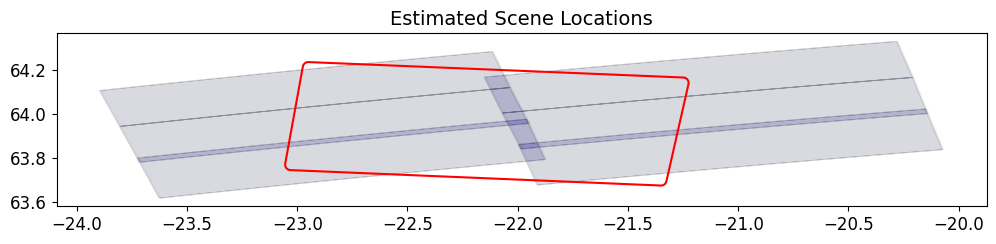

In [87]:
#Genera un gráfico que muestra la ubicación de las escenas Sentinel-1 en un mapa, utilizando el área de
#interés (AOI) como referencia.

sbas.plot_scenes(AOI=AOI)

## Reframe Scenes (Optional)

Stitch sequential scenes and crop the subswath to a smaller area for faster processing when the full area is not needed.

## ¿Qué hace la sección "Reframe Scenes"?

Se encarga de recortar y unir escenas Sentinel-1 para optimizar el procesamiento InSAR. Es un paso opcional pero recomendable, especialmente cuando se trabaja con áreas de interés (AOI) específicas.

In [88]:
## Esta función realiza el corte y la unión (stitching) de las escenas Sentinel-1.

sbas.compute_reframe(AOI)

Reframing: 01...16 from 38:   0%|          | 0/32 [00:00<?, ?it/s]

Reframing: 17...32 from 38:   0%|          | 0/32 [00:00<?, ?it/s]

Reframing: 33...38 from 38:   0%|          | 0/12 [00:00<?, ?it/s]

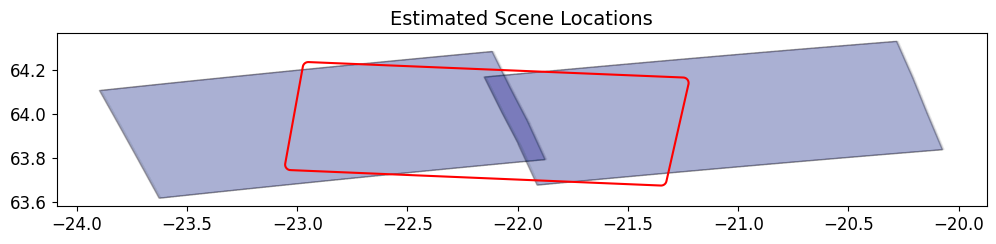

In [89]:
#genera un gráfico que muestra las escenas recortadas y unidas en un mapa, utilizand el AOI como referencia.

sbas.plot_scenes(AOI=AOI)

# Beneficios del "Reframe Scenes"
- Reducción del tiempo de procesamiento: al trabajar con escenas más pequeñas y enfocadas en el área de interés, se reduce la cantidad de datos que se deben procesar, lo que acelera el análisis.
- Menor consumo de memoria: las escenas recortadas ocupan menos espacio en la memoria RAM, lo que permite procesar datasets más grandes en máquinas con recursos limitados.

### Load DEM

The function below loads DEM from file or Xarray variable and converts heights to ellipsoidal model using EGM96 grid.

# ¿Para qué sirve cargar un DEM?

En el procesamiento InSAR, el Modelo Digital de Elevación (DEM) es fundamental para:

- **Corrección topográfica:** el DEM se utiliza para eliminar la influencia del relieve del terreno en las mediciones de deformación.

- **Geocodificación:** el DEM perite transformar las coordenadas de as imágenes SAR a un sistema de coordenadas geográficas.

In [90]:
# Se utilizará el área de interés (AOI) para acelerar el procesamiento al cargar
# solo la porción del DEM que se necesita.
sbas.load_dem(DEM, AOI)

Save DEM on WGS84 Ellipsoid:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

INFO:distributed.scheduler:Receive client connection: Client-worker-821b95d0-d386-11ef-9502-0242ac1c0002
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:48530
INFO:distributed.scheduler:Receive client connection: Client-worker-82228b14-d386-11ef-94fe-0242ac1c0002
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:48536


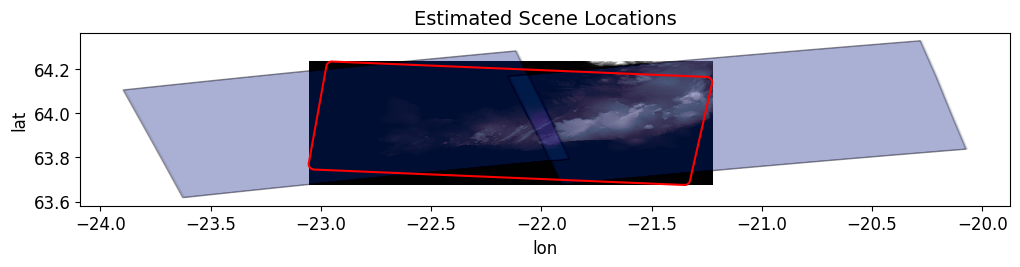

In [91]:
# Este código se encarga de generar un gráfico que muestra la ubicación de las escenas
# Sentinel-1 y luego guardar ese gráfico como una imagen JPG

sbas.plot_scenes(AOI=AOI)


# ¿Por qué es útil lo anterior?

Este código es útil para:

- **Visualizar la cobertura geográfica de las escenas:** te permite ver rápidamente qué áreas están cubiertas por las imágenes Sentinel-1 que se utilizarán en el procesamiento InSAR.

- **Verficar la ubicación del AOI:** te ayuda a confirmar que el área de interés está completamente definida y que las escenas las cubren adecuadamente.

- **Documentar el análisis:** guardar el gráfico como una imagen permite tener un registro visual de la ubicación de las escenas, lo cual es útil para la documentación del proyecto.

## Align Images

Esta sección se encarga de alinear las imágenes Sentinel-1 para que estén correctamente superpuestas antes de generar los interferogramas. La alineación precisa es crucial para obtener resultados InSAR de calidad.

In [93]:
# Se utiliza la función copute_align() del objeto sbas (que representa el conjunto de escenas
# para el procesamiento InSAR) para realizar la alineación de las imágenes.
# PyGMTSAR utiliza algoritmos de correlación cruzada para encontrar el desplazamiento entre las
# imágenes y alinearlas con precisión.

sbas.compute_align()

Preparing Reference:   0%|          | 0/2 [00:00<?, ?it/s]

Aligning Repeat:   0%|          | 0/74 [00:00<?, ?it/s]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/joblib/parallel.py", line 1650, in _get_outputs
    yield from self._retrieve()
  File "/usr/local/lib/python3.10/dist-packages/joblib/parallel.py", line 1762, in _retrieve
    time.sleep(0.01)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-93-dc1e32e1d564>", line 6, in <cell line: 6>
    sbas.compute_align()
  File "/usr/local/lib/python3.10/dist-packages/pygmtsar/Stack_align.py", line 388, in compute_align
    joblib.Parallel(n_jobs=n_jobs, backend=joblib_backend)(joblib.delayed(self._align_rep_subswath)(subswath, date, degrees=degrees, debug=debug) \
  File "/usr/local/lib/python3.10/dist-packages/joblib/parallel.py", line 2007, in __call__
    re

TypeError: object of type 'NoneType' has no len()

# ¿Por qué es necesaria la alineación de imágenes?

Las imágenes Sentinel-1 pueden tener pequeños desplazamientos debido a la geoetría de adquisición, las variaciones en la órbita del satélite y otros factores. Si las imágenes no están correctamente alineadas, los interferogramas resultantes tendrán errores que afectarás la precisión de las mediciones de deformación.

# Geocoding Transform

Este sección se encarga de geocodificar las imágenes Sentinel-1, es decir, transformar las coordenadas de las imágenes desde el sistema de coordenadas del sensor (radar) a un sistema de coordenadas geográficas (latitud y longitud). Este proceso es fundamental para poder visualizar y analizar los resultados InSAR en un contexto geográfico real.




In [ ]:
# Se utiliza la configuración predeterminada de PyGMTSAR para la geocodificación,
# que genera una malla de coordenadas geográficas con una resolución de 60 metros.

# PyGMTSAR utiliza la información del DEM y las órbitas de los satélites
# para realizar la transformación de coordenadas. El resultado de la geocodificación es un conjunto
# de imágenes que están georreferenciadas, es decir, que cada pixel de la imagen tiene una ubicación
# geográfica definida.

sbas.compute_geocode(1)

In [ ]:
# Este código se encarga de generar un gráfico de la topografía utilizando el DEM
#cargado previamente y luego guardar ese gráfico como una imagen JPG.

sbas.plot_topo(quantile=[0.01, 0.99])

# SBAS Baseline


In [ ]:
baseline_pairs = sbas.sbas_pairs(days=6)
# optionally, drop dates having less then 2 pairs
#baseline_pairs = sbas.sbas_pairs_limit(baseline_pairs, limit=2, iterations=2)
# Para excluir ciertas fechas específicas (por ejemplo, debido a datos defectuosos o anomalías)
# se debe usar la siguiente línea de código
#baseline_pairs = sbas.sbas_pairs_filter_dates(baseline_pairs, ['2021-01-01'])
baseline_pairs

In [ ]:
# Utilizaremos un context manager, el cual permitirá modificar configuraciones de manera temporal,
# de modo que sólo se apliquen dentro de un bloque de código específico y se restauren después de
# ejecutarlo

with mpl_settings({'figure.dpi': 300}):
    sbas.plot_baseline(baseline_pairs)

# dpi (dots per inch): controla la cantidad de píxeles por pulgada en la figura. Un valor de 300
# indica una resulución alta, lo que resulta en una imagen más nítida y detallada.

## Persistent Scatterers Function (PSF)

In [ ]:
# El objetivo principal es calcular una función de scatterers persistentes, que
# se usa para identificar puntos estables en la superficie terrestre.
sbas.compute_ps()

In [ ]:
# Se genera un gráfico de la PSF, que muestra cómo varía la estabilidad de los puntos
# en el tiempo. Se limitan los valores visualizados a aquellos que están entre 1% y 90%,
# pues los demás pueden tener pérdida de coherencia.

sbas.plot_psfunction(quantile=[0.01, 0.90])

## SBAS Analysis

### Multi-looked Resolution for SBAS

In [ ]:
# Se toman los pares de imágenes seleccionados y se calculan los interferogramas. Este paso
# ayuda a reducir el ruido den los datos interferométricos

sbas.compute_interferogram_multilook(baseline_pairs, 'intf_mlook', wavelength=30, weight=sbas.psfunction())

In [ ]:
# Este código abre el stack intf_mlook y extrae la fase interferométrica (datos
# utilizados para analizar deformaciones en la superficie)
ds_sbas = sbas.open_stack('intf_mlook')
intf_sbas = ds_sbas.phase
corr_sbas = ds_sbas.correlation
corr_sbas

In [ ]:
intf_sbas

In [ ]:
sbas.plot_interferograms(intf_sbas[:8], caption='SBAS Phase, [rad]')

In [ ]:
sbas.plot_correlations(corr_sbas[:8], caption='SBAS Correlation')

### 2D Unwrapping

In [ ]:
unwrap_sbas = sbas.unwrap_snaphu(intf_sbas, corr_sbas)
unwrap_sbas

In [ ]:
# Se sincroniza y materializan los datos desenrollados de fase en un archivo
# en disco para facilitar su uso posterior
unwrap_sbas = sbas.sync_cube(unwrap_sbas, 'unwrap_sbas')

In [ ]:
sbas.plot_phases(unwrap_sbas.phase[:8], caption='SBAS Phase, [rad]')

### Trend Correction

In [ ]:
decimator = sbas.decimator(resolution=15, grid=(1,1))
topo = decimator(sbas.get_topo())
inc = decimator(sbas.incidence_angle())
yy, xx = xr.broadcast(topo.y, topo.x)
trend_sbas = sbas.regression(unwrap_sbas.phase,
        [topo,    topo*yy,    topo*xx,    topo*yy*xx,
         topo**2, topo**2*yy, topo**2*xx, topo**2*yy*xx,
         topo**3, topo**3*yy, topo**3*xx, topo**3*yy*xx,
         inc,     inc**yy,    inc*xx,     inc*yy*xx,
         yy, xx,
         yy**2, xx**2, yy*xx,
         yy**3, xx**3, yy**2*xx, xx**2*yy], corr_sbas)

In [ ]:
# Guarda la tendencia de deformación calculada en un archivo llamado 'trend_sbas'
trend_sbas = sbas.sync_cube(trend_sbas, 'trend_sbas')

In [ ]:
sbas.plot_phases(trend_sbas[:8], caption='SBAS Trend Phase, [rad]', quantile=[0.01, 0.99])

In [ ]:
sbas.plot_phases((unwrap_sbas.phase - trend_sbas)[:8], caption='SBAS Phase - Trend, [rad]', vmin=-np.pi, vmax=np.pi)

### Coherence-Weighted Least-Squares Solution for LOS Displacement, mm

In [ ]:
# Calcula el desplazamiento a lo largo de la línea de visión (LOS) en milímetros
# a partir de los datos de fase desenrrollada. Recordemos que LOS es la línea
# imaginaria que conecta el satélite con un punto en la superficie terrestre.

disp_sbas = sbas.los_displacement_mm(sbas.lstsq(unwrap_sbas.phase - trend_sbas, corr_sbas))

# Acá se resta la tendencia de fondo, dejando los cambios residuales que realmente reflejan
# la deformación del terreno

In [ ]:
# Corresponde al mapa final de desplazamiento LOS en milímetros
disp_sbas = sbas.sync_cube(disp_sbas, 'disp_sbas')

In [ ]:
# Genera un mapa que muestra los desplazamientos acumulados en la línea de visión (LOS), medidos en milímetros

sbas.plot_displacements(disp_sbas[::3], caption='SBAS Cumulative LOS Displacement, [mm]', quantile=[0.01, 0.99])

### Least-squares model for LOS Displacement, mm

In [ ]:
velocity_sbas = sbas.velocity(disp_sbas)
velocity_sbas

In [ ]:
# optionally, materialize to disk and open
velocity_sbas = sbas.sync_cube(velocity_sbas, 'velocity_sbas')

In [ ]:
fig = plt.figure(figsize=(12,4), dpi=300)

zmin, zmax = np.nanquantile(velocity_sbas, [0.01, 0.99])
zminmax = max(abs(zmin), zmax)

ax = fig.add_subplot(1, 2, 1)
velocity_sbas.plot.imshow(cmap='turbo', vmin=-zminmax, vmax=zminmax, ax=ax)
sbas.geocode(AOI.buffer(-BUFFER).boundary).plot(ax=ax)
sbas.geocode(POI).plot(ax=ax, marker='x', c='r', markersize=100, label='POI')
sbas.geocode(POI0).plot(ax=ax, marker='x', c='b', markersize=100, label='POI$\Theta$')
ax.set_aspect('auto')
ax.set_title('Velocity, mm/year', fontsize=16)

ax = fig.add_subplot(1, 2, 2)
sbas.as_geo(sbas.ra2ll(velocity_sbas)).rio.clip(AOI.geometry.buffer(-BUFFER))\
    .plot.imshow(cmap='turbo', vmin=-zminmax, vmax=zminmax, ax=ax)
AOI.buffer(-BUFFER).boundary.plot(ax=ax)
POI.plot(ax=ax, marker='x', c='r', markersize=100, label='POI')
POI0.plot(ax=ax, marker='x', c='b', markersize=100, label='POI$\Theta$')
ax.legend(loc='upper left', fontsize=14)
ax.set_title('Velocity, mm/year', fontsize=16)

plt.suptitle('SBAS LOS Velocity, 2021', fontsize=18)
plt.tight_layout()
plt.show()

### STL model for LOS Displacement, mm

In [ ]:
plt.figure(figsize=(12, 4), dpi=300)

x, y = [(geom.x, geom.y) for geom in sbas.geocode(POI).geometry][0]
disp_pixel = disp_sbas.sel(y=y, x=x, method='nearest')
stl_pixel = sbas.stl(disp_sbas.sel(y=[y], x=[x], method='nearest')).isel(x=0, y=0)
plt.plot(disp_pixel.date, disp_pixel, c='r', lw=2, label='Displacement POI')
plt.plot(stl_pixel.date, stl_pixel.trend, c='r', ls='--', lw=2, label='Trend POI')
plt.plot(stl_pixel.date, stl_pixel.seasonal, c='r', lw=1, label='Seasonal POI')

x, y = [(geom.x, geom.y) for geom in sbas.geocode(POI0).geometry][0]
disp_pixel = disp_sbas.sel(y=y, x=x, method='nearest')
stl_pixel = sbas.stl(disp_sbas.sel(y=[y], x=[x], method='nearest')).isel(x=0, y=0)
plt.plot(disp_pixel.date, disp_pixel, c='b', lw=2, label='Displacement POI$\Theta$')
plt.plot(stl_pixel.date, stl_pixel.trend, c='b', ls='--', lw=2, label='Trend POI$\Theta$')
plt.plot(stl_pixel.date, stl_pixel.seasonal, c='b', lw=1, label='Seasonal POI$\Theta$')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=14)
plt.title('SBAS LOS Displacement STL Decompose, 2021', fontsize=18)
plt.ylabel('Displacement, mm', fontsize=16)
plt.show()

## PS Analysis

Use the trend detected on possibly lower resolution unwrapped phases for higher resolution analysis.

In [ ]:
sbas.compute_interferogram_singlelook(baseline_pairs, 'intf_slook', wavelength=30,
                                      weight=sbas.psfunction(), phase=trend_sbas)

In [ ]:
# optionally, materialize to disk and open
ds_ps = sbas.open_stack('intf_slook')
intf_ps = ds_ps.phase
corr_ps = ds_ps.correlation

In [ ]:
sbas.plot_interferograms(intf_ps[:8], caption='PS Phase, [rad]')

In [ ]:
sbas.plot_correlations(corr_ps[:8], caption='PS Correlation')

### 1D Unwrapping and LOS Displacement, mm

In [ ]:
disp_ps_pairs = sbas.los_displacement_mm(sbas.unwrap1d(intf_ps))
disp_ps_pairs

In [ ]:
# optionally, materialize to disk and open
disp_ps_pairs = sbas.sync_cube(disp_ps_pairs, 'disp_ps_pairs')

### Coherence-Weighted Least-Squares Solution for LOS Displacement, mm

In [ ]:
disp_ps = sbas.lstsq(disp_ps_pairs, corr_ps)
disp_ps

In [ ]:
# optionally, materialize to disk and open
disp_ps = sbas.sync_cube(disp_ps, 'disp_ps')

In [ ]:
zmin, zmax = np.nanquantile(disp_ps, [0.01, 0.99])
sbas.plot_displacements(disp_ps[::3], caption='PS Cumulative LOS Displacement, [mm]', vmin=zmin, vmax=zmax)

### Least-squares model for LOS Displacement, mm

In [ ]:
velocity_ps = sbas.velocity(disp_ps)
velocity_ps

In [ ]:
# optionally, materialize to disk and open
velocity_ps = sbas.sync_cube(velocity_ps, 'velocity_ps')

In [ ]:
fig = plt.figure(figsize=(12,4), dpi=300)

zmin, zmax = np.nanquantile(velocity_ps, [0.01, 0.99])
zminmax = max(abs(zmin), zmax)

ax = fig.add_subplot(1, 2, 1)
velocity_ps.plot.imshow(cmap='turbo', vmin=-zminmax, vmax=zminmax, ax=ax)
sbas.geocode(AOI.buffer(-BUFFER).boundary).plot(ax=ax)
sbas.geocode(POI).plot(ax=ax, marker='x', c='r', markersize=100, label='POI')
sbas.geocode(POI0).plot(ax=ax, marker='x', c='b', markersize=100, label='POI$\Theta$')
ax.set_aspect('auto')
ax.set_title('Velocity, mm/year', fontsize=16)

ax = fig.add_subplot(1, 2, 2)
sbas.as_geo(sbas.ra2ll(velocity_ps)).rio.clip(AOI.geometry.buffer(-BUFFER))\
    .plot.imshow(cmap='turbo', vmin=-zminmax, vmax=zminmax, ax=ax)
AOI.buffer(-BUFFER).boundary.plot(ax=ax)
POI.plot(ax=ax, marker='x', c='r', markersize=100, label='POI')
POI0.plot(ax=ax, marker='x', c='b', markersize=100, label='POI$\Theta$')
ax.legend(loc='upper left', fontsize=14)
ax.set_title('Velocity, mm/year', fontsize=16)

plt.suptitle('PS LOS Velocity, 2021', fontsize=18)
plt.tight_layout()
plt.show()

### STL model for LOS Displacement, mm

In [ ]:
plt.figure(figsize=(12, 4), dpi=300)

x, y = [(geom.x, geom.y) for geom in sbas.geocode(POI).geometry][0]
disp_pixel = disp_ps.sel(y=y, x=x, method='nearest')
stl_pixel = sbas.stl(disp_ps.sel(y=[y], x=[x], method='nearest')).isel(x=0, y=0)
plt.plot(disp_pixel.date, disp_pixel, c='r', lw=2, label='Displacement POI')
plt.plot(stl_pixel.date, stl_pixel.trend, c='r', ls='--', lw=2, label='Trend POI')
plt.plot(stl_pixel.date, stl_pixel.seasonal, c='r', lw=1, label='Seasonal POI')

x, y = [(geom.x, geom.y) for geom in sbas.geocode(POI0).geometry][0]
disp_pixel = disp_ps.sel(y=y, x=x, method='nearest')
stl_pixel = sbas.stl(disp_ps.sel(y=[y], x=[x], method='nearest')).isel(x=0, y=0)
plt.plot(disp_pixel.date, disp_pixel, c='b', lw=2, label='Displacement POI$\Theta$')
plt.plot(stl_pixel.date, stl_pixel.trend, c='b', ls='--', lw=2, label='Trend POI$\Theta$')
plt.plot(stl_pixel.date, stl_pixel.seasonal, c='b', lw=1, label='Seasonal POI$\Theta$')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=14)
plt.title('PS LOS Displacement STL Decompose, 2021', fontsize=18)
plt.ylabel('Displacement, mm', fontsize=16)
plt.show()

In [ ]:
x, y = [(geom.x, geom.y) for geom in sbas.geocode(POI0).geometry][0]
sbas.plot_baseline_displacement_los_mm(disp_ps_pairs.sel(y=y, x=x, method='nearest')/sbas.los_displacement_mm(1),
                                corr_ps.sel(y=y, x=x, method='nearest'),
                               caption='POI0', stl=True)

In [ ]:
x, y = [(geom.x, geom.y) for geom in sbas.geocode(POI).geometry][0]
sbas.plot_baseline_displacement_los_mm(disp_ps_pairs.sel(y=y, x=x, method='nearest')/sbas.los_displacement_mm(1),
                                corr_ps.sel(y=y, x=x, method='nearest'),
                               caption='POI', stl=True)

### RMSE Error Estimation

In [ ]:
rmse_ps = sbas.rmse(disp_ps_pairs, disp_ps, corr_ps)
rmse_ps

In [ ]:
# optionally, materialize to disk and open
rmse_ps = sbas.sync_cube(rmse_ps, 'rmse_ps')

In [ ]:
sbas.plot_rmse(rmse_ps, caption='RMSE Correlation Aware, [mm]')

## SBAS vs PS Comparision

In [ ]:
# crop AOI
points_sbas = sbas.as_geo(sbas.ra2ll(velocity_sbas)).rio.clip(AOI.geometry)
points_ps = sbas.as_geo(sbas.ra2ll(velocity_ps)).rio.clip(AOI.geometry)
points_ps = points_ps.interp_like(points_sbas, method='nearest').values.ravel()
points_sbas = points_sbas.values.ravel()
nanmask = np.isnan(points_sbas) | np.isnan(points_ps)
points_sbas = points_sbas[~nanmask]
points_ps = points_ps[~nanmask]

In [ ]:
plt.figure(figsize=(12, 4), dpi=300)
plt.scatter(points_sbas, points_ps, c='silver', alpha=1,   s=1)
plt.scatter(points_sbas, points_ps, c='b',      alpha=0.1, s=1)
plt.scatter(points_sbas, points_ps, c='g',      alpha=0.1, s=0.1)
plt.scatter(points_sbas, points_ps, c='y',      alpha=0.1, s=0.01)

# adding a 1:1 line
max_value = max(velocity_sbas.max(), velocity_ps.max())
min_value = min(velocity_sbas.min(), velocity_ps.min())
plt.plot([min_value, max_value], [min_value, max_value], 'k--')

plt.xlabel('Velocity SBAS, mm/year', fontsize=16)
plt.ylabel('Velocity PS, mm/year', fontsize=16)
plt.title('Cross-Comparison between SBAS and PS Velocity', fontsize=18)
plt.grid(True)
plt.show()

## 3D Interactive Map

In [ ]:
velocity_sbas_ll = sbas.ra2ll(velocity_sbas)
velocity_ps_ll = sbas.ra2ll(velocity_ps)
# crop to area
velocity_sbas_ll = sbas.as_geo(velocity_sbas_ll).rio.clip(AOI.geometry.buffer(-BUFFER))
velocity_ps_ll = sbas.as_geo(velocity_ps_ll).rio.clip(AOI.geometry.buffer(-BUFFER))
# export VTK
sbas.export_vtk(velocity_sbas_ll, 'velocity_sbas', mask='auto')
sbas.export_vtk(velocity_ps_ll,   'velocity_ps', mask='auto')

In [ ]:
gmap = XYZTiles().download(velocity_sbas_ll, 15)
gmap.plot.imshow()
sbas.export_vtk(None, 'gmap', image=gmap, mask='auto')

In [ ]:
plotter = pv.Plotter(shape=(1, 2), notebook=True)
axes = pv.Axes(show_actor=True, actor_scale=2.0, line_width=5)

vtk_map = pv.read('gmap.vtk').scale([1, 1, 0.00002]).rotate_z(135)


plotter.subplot(0, 0)
vtk_grid = pv.read('velocity_sbas.vtk').scale([1, 1, 0.00002]).rotate_z(135)
plotter.add_mesh(vtk_map.scale([1, 1, 0.999]), scalars='colors', rgb=True, ambient=0.2)
plotter.add_mesh(vtk_grid, scalars='trend', ambient=0.5, opacity=0.8, cmap='turbo', clim=(-30,30), nan_opacity=0.1, nan_color='black')
plotter.show_axes()
plotter.add_title('SBAS LOS Velocity', font_size=32)

plotter.subplot(0, 1)
vtk_grid = pv.read('velocity_ps.vtk').scale([1, 1, 0.00002]).rotate_z(135)
plotter.add_mesh(vtk_map.scale([1, 1, 0.999]), scalars='colors', rgb=True, ambient=0.2)
plotter.add_mesh(vtk_grid, scalars='trend', ambient=0.5, opacity=0.8, cmap='turbo', clim=(-30,30), nan_opacity=0.1, nan_color='black')
plotter.show_axes()
plotter.add_title('PS LOS Velocity', font_size=32)

plotter.show_axes()
plotter._on_first_render_request()
panel.panel(
    plotter.render_window, orientation_widget=plotter.renderer.axes_enabled,
    enable_keybindings=False, sizing_mode='stretch_width', min_height=600
)

## Export VTK file from Google Colab

In [ ]:
if 'google.colab' in sys.modules:
    from google.colab import files
    files.download('velocity_sbas.vtk')
    files.download('velocity_ps.vtk')

## Conclusion